<a href="https://colab.research.google.com/github/AnushkaKokate/Deepfake-Detection/blob/main/Deepfake_Detection_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#dataset link https://www.kaggle.com/c/deepfake-detection-challenge/data

In [ ]:
!python --version

Python 3.7.13


In [ ]:
#
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance
import os
#Image Processing Libraries

In [ ]:
#Generating image dataset from videos, extract images from video frames in which face is detecetd
train_frame_folder = '/content/drive/MyDrive/Colab Notebooks/deepfake detection/Deepfake/train_sample_videos'
with open(os.path.join(train_frame_folder, 'metadata.json'), 'r') as file:
    data = json.load(file)
list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()
for vid in list_of_train_data:
    count = 0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]
                if data[vid]['label'] == 'REAL':
                    cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/deepfake detection/Deepfake/dataset/real/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (128, 128)))
                elif data[vid]['label'] == 'FAKE':
                    cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/deepfake detection/Deepfake/dataset/fake/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (128, 128)))
                count+=1

In [ ]:
#
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
#
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
#Image to numerical array
input_shape = (128, 128, 3)
data_dir = '/content/drive/MyDrive/Colab Notebooks/deepfake detection/Deepfake/dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [ ]:
transfer_learning_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
transfer_learning_model.trainable = True
model = Sequential()
model.add(transfer_learning_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

219070464/219055592 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#Currently not used
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 20
BATCH_SIZE = 64
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)
model.save("/content/drive/My Drive/Deepfake/model_new1.h5")

Epoch 1/20
47/47 [==============================] - 51s 482ms/step - loss: 0.7111 - accuracy: 0.4613 - val_loss: 0.7272 - val_accuracy: 0.5594
Epoch 2/20
47/47 [==============================] - 17s 353ms/step - loss: 0.5808 - accuracy: 0.7430 - val_loss: 0.6778 - val_accuracy: 0.5581
Epoch 3/20
47/47 [==============================] - 17s 358ms/step - loss: 0.4782 - accuracy: 0.8421 - val_loss: 0.6543 - val_accuracy: 0.5754
Epoch 4/20
47/47 [==============================] - 17s 360ms/step - loss: 0.3941 - accuracy: 0.8868 - val_loss: 0.6137 - val_accuracy: 0.6649
Epoch 5/20
47/47 [==============================] - 17s 364ms/step - loss: 0.3117 - accuracy: 0.9186 - val_loss: 0.5704 - val_accuracy: 0.7597
Epoch 6/20
47/47 [==============================] - 17s 369ms/step - loss: 0.2485 - accuracy: 0.9379 - val_loss: 0.5083 - val_accuracy: 0.8211
Epoch 7/20
47/47 [==============================] - 18s 374ms/step - loss: 0.1934 - accuracy: 0.9526 - val_loss: 0.4427 - val_accuracy: 0.8451

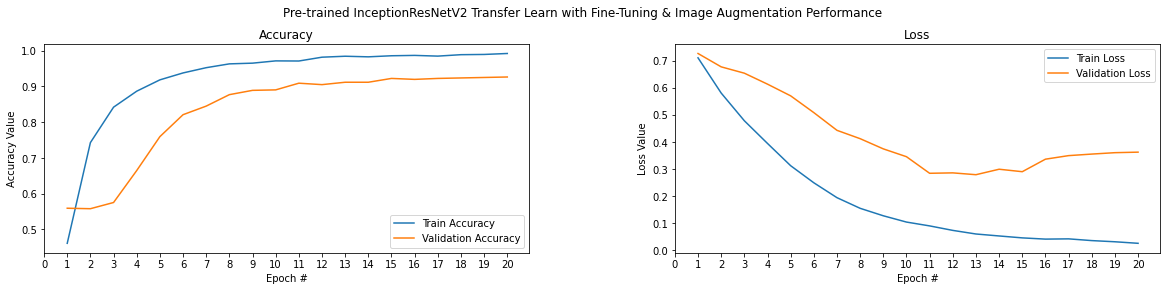

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

True positive =  2957
False positive =  29
False negative =  47
True negative =  712




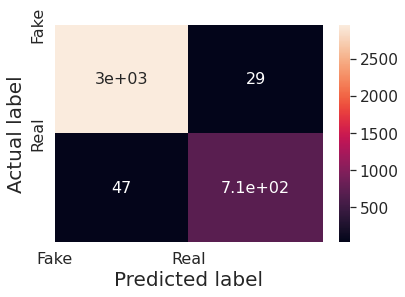

In [ ]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
#Prediction
prediction = model.predict(X)
test_prediction=[]
for pred in prediction:
  if(pred[0] > pred[1]):
    test_prediction.append(0)
  else:
    test_prediction.append(1)

print_confusion_matrix(Y_val_org, test_prediction)